# C. elegans connectom alnalysis

In [1]:
import numpy as np
from numpy import random as rdom
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

In [2]:
def random_net(N,p):
    network=np.array([])
    for i in range(N):
        line=np.append(np.zeros(i+1),rdom.choice([1,0],size=(N-(i+1)),p=[p,1-p]))
        network=np.append(network,line)
    network=network.reshape((N,N))
    network=network + np.transpose(network)
    return network

def drandom_net(N,p):
    network = rdom.choice([1,0],size=(N,N),p=[p,1-p])
    np.fill_diagonal(network,0)
    return network

In [128]:
def connectivity(network,direction=False):
    
    if network.sum()==0:
        print("There is no connection.")
        
    connection=np.transpose(np.where(network==1))
    if direction:
        graph=graphviz.dot.Digraph(comment='Connectivity')
        
        for xdx,ydx in connection: # edge 설정
            graph.edge(str(xdx),str(ydx))
    else:
        graph=graphviz.dot.Graph(comment='Connectivity')
        connection=np.transpose(np.where(network==1)).tolist()

        '''
        for idx in range(network.shape[0]):
            graph.node(str(idx))
        '''
        for xdx,ydx in connection: #양방향성 제거.
            connection.remove([ydx,xdx])
            
        for xdx,ydx in connection:
            graph.edge(str(xdx),str(ydx))
    
    return graph

In [4]:
def kcore_net(network,k,direction=False):
    now_net=network.copy()
    old_net=np.zeros(network.size)
    while not np.all(old_net.ravel() ==now_net.ravel()):
        old_net=now_net.copy()
        
        if not direction: #undirectional
            degree=now_net.sum(axis=0)
            
        elif direction=='out': #only output
            degree=now_net.sum(axis=1)
        elif direction=='in': #only input
            degree=now_net.sum(axis=0)
            
        elif direction: #directional
            degree=now_net.sum(axis=0)+now_net.sum(axis=1)
            
        where=np.where(degree < k)
        
        now_net[where]=0
        now_net[:,where]=0
    return now_net

In [5]:
def node_percolation(network,q):
    
    net=network.copy()
    
    #Node number
    N_node=net.shape[0]
    
    #removed node selection
    sel_node=np.where(rdom.choice([0,1],N_node,p=[1-q,q])) #1: remove 0: do not.
    
    #remove the nodes
    net[sel_node]=0
    net[:,sel_node]=0
    
    return net

# Test k-core algorithm for Directional graph
The main differances between a randome graph and real data is that the real data is directional and weighted. So I selected avoiding way.
Unlike my previous code, the type of graph on connectome is a directional graph, not a undirectional one. So, I tested my code for directional graph. And fortunately it work.
Also I remove weight, and make them "1"(connected or not("0")). If you want to use weighted values, just do "-1" operation and "min(0,calculated value)" for selected nodes in the abjacent matrix.
Fortunately my code is applied for only a node percolation, not a bond percolation, so I did not need to change my code. If you want to do bond percolation, just change\
"sel_node=np.where(rdom.choice([0,1],N_node,p=[1-q,q]))" \
to\
"net * rdom.choice([0,1],N_node**2,p=[1-q,q]).reshape(N_node,N_node);".

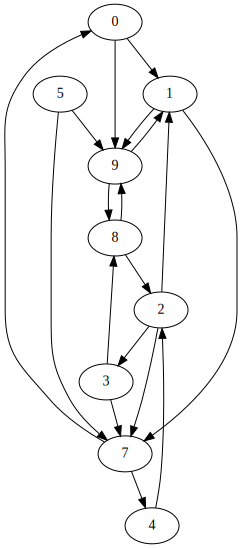

In [6]:
graph=drandom_net(10,0.2)
connectivity(graph,direction="True")

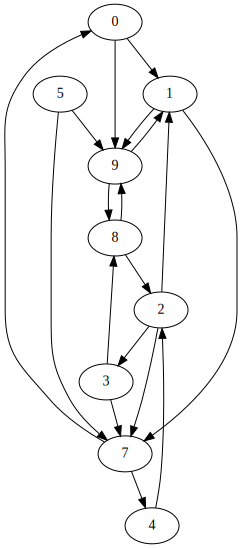

In [7]:
k_core_test=kcore_net(graph,2,direction=True)
connectivity(k_core_test,direction='True')

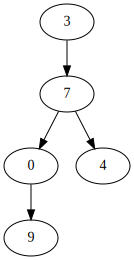

In [8]:
per_net_test=node_percolation(graph,0.4)
connectivity(per_net_test,direction=True)

# Excel to Adjacent Matrix

The C.elgans connectome data is not a N by N adjacent matrix, it only has values where connection exists. So I made it to be N by N matrix by adding rows or columns having only "0" values.

In [9]:
df=pd.read_excel('C_elegans_Connectome.xlsx',sheet_name='male chemical',
                 usecols='C:VF',header=2,index_col=0)[:-1]
df=df.fillna(0)

In [10]:
df2=pd.DataFrame(np.zeros([max(df.shape),max(df.shape)]))
df

,I1L,I1R,I2L,I2R,I3,I4,I5,I6,M1,M2L,...,vsrR,gonad,proctodeum,R1stR,R2stR,R3stL,R5stL,R7stL,R7stR,R9stL
I1L,0,0,10,0,3,0,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
I1R,0,0,0,6,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
I2L,2,0,0,3,0,13,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
I2R,0,1,3,0,0,20,2,3,3,0,...,0,0,0,0,0,0,0,0,0,0
I3,1,1,0,0,0,0,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP05,0,0,0,0,0,0,0,0,0,0,...,0,46,0,0,0,0,0,0,0,0
CP06,0,0,0,0,0,0,0,0,0,0,...,0,43,0,0,0,0,0,0,0,0
CP07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CP08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
count=0
zero_fil=np.zeros(max(df.shape))
max_count=min(df.shape)-1
for idx, row_name in enumerate(df.columns):
    if df.index[count] == row_name:
        df2.iloc[idx]=np.array(df.iloc[count])
        count = min(count+1,max_count) 
    else:
        df2.iloc[idx]=zero_fil
df2=(df2>0).astype(int)

In [12]:
df2.columns=df.columns
df2.index=df.columns
df2

,I1L,I1R,I2L,I2R,I3,I4,I5,I6,M1,M2L,...,vsrR,gonad,proctodeum,R1stR,R2stR,R3stL,R5stL,R7stL,R7stR,R9stL
I1L,0,0,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
I1R,0,0,0,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
I2L,1,0,0,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
I2R,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
I3,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R3stL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R5stL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R7stL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R7stR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#df2.to_excel('check.xlsx')

In [14]:
img_dic={"Pharynx":49,"Sensory":132,"Interneuron":213,"Motor neuron":436,"Sex-specific":574}

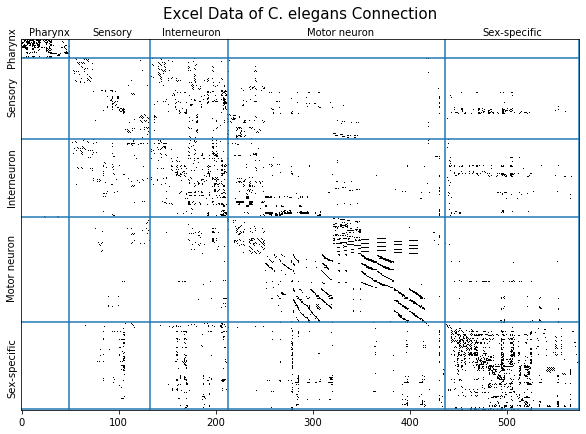

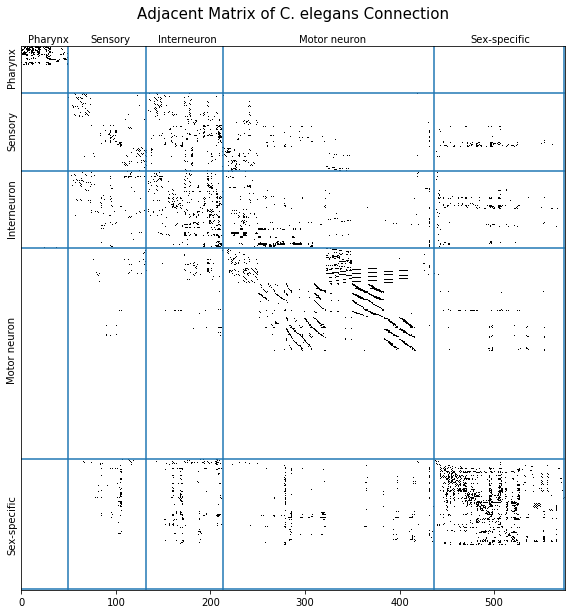

In [15]:
figsize=10
col_dic={"Pharynx":19,"Sensory":102,"Interneuron":183,"Motor neuron":291,"Sex-specific":381}
plt.figure("Excel",figsize=figsize*np.array([1,1]))
plt.imshow(df>0,cmap='Greys')
plt.title("Excel Data of C. elegans Connection",loc='center',y=1.04,fontsize=15)

portion=0
portion2=0
for pos in img_dic:
    cen_row = int((img_dic[pos]+portion)/2)
    cen_col = int((col_dic[pos]+portion2)/2)
    plt.text(cen_row-int(figsize/4*len(pos)),-5,pos)
    plt.text(-15,int((cen_col+figsize/4*len(pos))),pos,rotation='vertical')
    plt.axhline(y=col_dic[pos])
    plt.axvline(x=img_dic[pos])
    ax=plt.gca()
    ax.get_yaxis().set_visible(False)
    portion=img_dic[pos]
    portion2=col_dic[pos]


plt.imshow(df>0,cmap='Greys')

figsize=10
plt.figure("Adjacent Matrix",figsize=figsize*np.array([1,1]))
plt.imshow(df2,cmap='Greys')
plt.title("Adjacent Matrix of C. elegans Connection",loc='center',y=1.04,fontsize=15)

portion=0
for pos in img_dic:
    cen_pos = int((img_dic[pos]+portion)/2)
    plt.text(cen_pos-int(figsize/4*len(pos)),-5,pos)
    plt.text(-15,int((cen_pos+figsize/4*len(pos))),pos,rotation='vertical')
    plt.axhline(y=img_dic[pos])
    plt.axvline(x=img_dic[pos])
    ax=plt.gca()
    ax.get_yaxis().set_visible(False)
    portion=img_dic[pos]

# Traits of C. elegans connectome

### Degree distribution

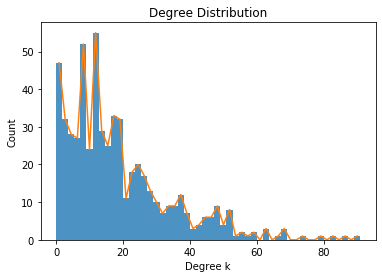

In [16]:
net=np.array(df2).copy()
net_degree=net.sum(axis=0)+net.sum(axis=1)

plt.figure("Degree Distribution")
plt.title("Degree Distribution")
net_hist=plt.hist(net_degree,bins=50,alpha=0.8)
plt.xlabel('Degree k')
plt.ylabel('Count')
x=(net_hist[1][:-1]+net_hist[1][1:])/2
plt.plot(x,net_hist[0])

### Best listener and talker

In [163]:
def idx2pos(name_dic,pos):
    count=0
    pre_pos=0
    for nam in name_dic:
        count += 1*(pre_pos<= pos <=name_dic[nam])
        pre_pos=pos
        if count == 1:
            return nam

Best Listener:		 hyp PVV
Best Listener position:	 Motor neuron Sex-specific
Maximum Listen Edge:	 49

Best Talker:		 R1BR
Best Talker position:	 Sex-specific
Maximum Talk Edge:	 50


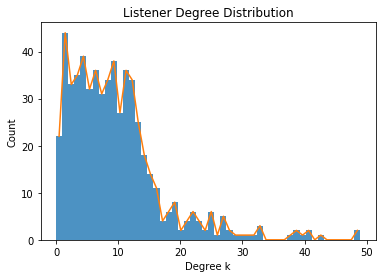

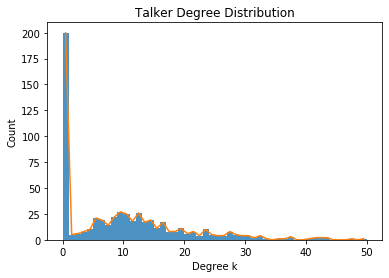

In [164]:
k_listener=net.sum(axis=0)
plt.figure("Listener Degree Distribution")
plt.title("Listener Degree Distribution")
listener_hist=plt.hist(k_listener,bins=50,alpha=0.8)
plt.xlabel('Degree k')
plt.ylabel('Count')
x=(listener_hist[1][:-1]+listener_hist[1][1:])/2
plt.plot(x,listener_hist[0])

best_listen_edge=k_listener.max()
best_listener_pos=np.where(k_listener==best_listen_edge)[0]
best_listener=df2.columns[best_listener_pos]

print('Best Listener:\t\t',*best_listener)
print('Best Listener position:\t',idx2pos(img_dic,best_listener_pos[0])
      ,idx2pos(img_dic,best_listener_pos[1]))
print('Maximum Listen Edge:\t',best_listen_edge)


k_talker=net.sum(axis=1)
plt.figure("Talker Degree Distribution")
plt.title("Talker Degree Distribution")
talker_hist=plt.hist(k_talker,bins=50,alpha=0.8)
plt.xlabel('Degree k')
plt.ylabel('Count')
x=(talker_hist[1][:-1]+talker_hist[1][1:])/2
plt.plot(x,talker_hist[0])

best_talk_edge=k_talker.max()
best_talker_pos=np.where(k_talker==best_talk_edge)[0]
best_talker=df2.columns[best_talker_pos]

print('\nBest Talker:\t\t',*best_talker)
print('Best Talker position:\t',idx2pos(img_dic,best_talker_pos[0]))
print('Maximum Talk Edge:\t',best_talk_edge)

# k core of C. elegans connectome
k-core is a component consisted of nodes that have at least k degree. You must note that any node that has below k degree is removed and the degree of some nodes are also change. This means that any edge which is connected with a node that has below k degree are non-counted as a k-core graph's edges. Therefore nodes are included in k-cores should be roots of least k-1 finite tree.  

In [19]:
dq=0.01
T=10
kcore_=np.arange(1,30,1)

net=np.array(df2)
N=max(np.shape(df2))

Mc=[]
q_=np.arange(0,1,dq)

for k in kcore_:
    print('-',k,'- core')
    for q in q_:
        node_count=0
        for idx in range(T):
            percol=node_percolation(net,q)
            k_net=kcore_net(percol,k,direction=True)
            node_count += 1*((k_net.sum(axis=0)+k_net.sum(axis=1)) >0).sum()
        Mc.append(node_count/(N*T))

Mc=np.array(Mc).reshape(len(kcore_),int(1/dq))

- 1 - core
- 2 - core
- 3 - core
- 4 - core
- 5 - core
- 6 - core
- 7 - core
- 8 - core
- 9 - core
- 10 - core
- 11 - core
- 12 - core
- 13 - core
- 14 - core
- 15 - core
- 16 - core
- 17 - core
- 18 - core
- 19 - core
- 20 - core
- 21 - core
- 22 - core
- 23 - core
- 24 - core
- 25 - core
- 26 - core
- 27 - core
- 28 - core
- 29 - core


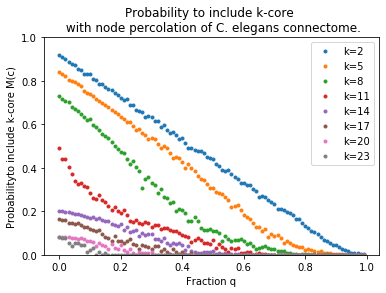

In [20]:
for idx,k in enumerate(kcore_[1:25:3]):
    plt.plot(q_,Mc[int(k-1)],'.',label='k='+str(k))
plt.ylim(0,1)
plt.title("Probability to include k-core \n with node percolation of C. elegans connectome.")
plt.xlabel("Fraction q")
plt.ylabel("Probabilityto include k-core M(c)")
plt.legend()
plt.show()

### $q_{c}$ vs $k-core$ Graph

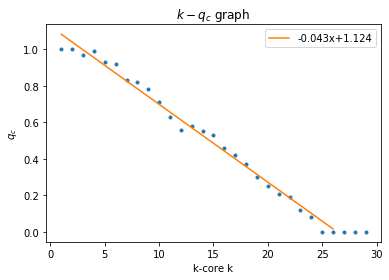

In [275]:
import scipy.optimize as opt

def lin(x,a,b):
    return a*x+b


qc=[]
for Mk in Mc:
    idx=np.where(Mk==0)[0]
    if len(idx)==0:
        qc.append(1)
    else:
        qc.append(q_[idx[0]])

x=np.linspace(1,26,100)  
        
plt.figure(r"$k-q_{c}$ graph")
plt.title(r"$k-q_{c}$ graph")
plt.ylabel(r"$q_{c}$")
plt.xlabel(r"k-core k")
plt.plot(kcore_,qc,'.')


popt,pcov = opt.curve_fit(lin,kcore_[:24],qc[:24])
plt.plot(x,lin(x,*popt),label=str(round(popt[0],3))+'x+'+str(round(popt[1],3)))
plt.legend()

# k-core position

In [244]:
k_net=kcore_net(net,24,direction=True)
#connectivity(k_net,direction=True).render("24-core.png")
k_net_degree=k_net.sum(axis=0)+k_net.sum(axis=1)
k_net_pos=np.where(k_net_degree)[0]
k_net_nam=df2.columns[k_net_pos]
for idx in k_net_pos:
    print('name:',df2.columns[idx])
    print('positon:',idx2pos(img_dic,idx))

name: PHCL
positon: Sensory
name: PHCR
positon: Sensory
name: AVFL
positon: Interneuron
name: AVFR
positon: Interneuron
name: PVNL
positon: Interneuron
name: PVNR
positon: Interneuron
name: AVG
positon: Interneuron
name: PDB
positon: Motor neuron
name: R1BR
positon: Sex-specific
name: R2BL
positon: Sex-specific
name: R2BR
positon: Sex-specific
name: R3BL
positon: Sex-specific
name: R3BR
positon: Sex-specific
name: R4BL
positon: Sex-specific
name: R4BR
positon: Sex-specific
name: R5BR
positon: Sex-specific
name: R6AR
positon: Sex-specific
name: R7AL
positon: Sex-specific
name: R7AR
positon: Sex-specific
name: R7BL
positon: Sex-specific
name: R7BR
positon: Sex-specific
name: R8AL
positon: Sex-specific
name: R8BL
positon: Sex-specific
name: R8BR
positon: Sex-specific
name: R9AL
positon: Sex-specific
name: R9AR
positon: Sex-specific
name: R9BL
positon: Sex-specific
name: R9BR
positon: Sex-specific
name: PHDL
positon: Sex-specific
name: PHDR
positon: Sex-specific
name: HOA
positon: Sex-spec

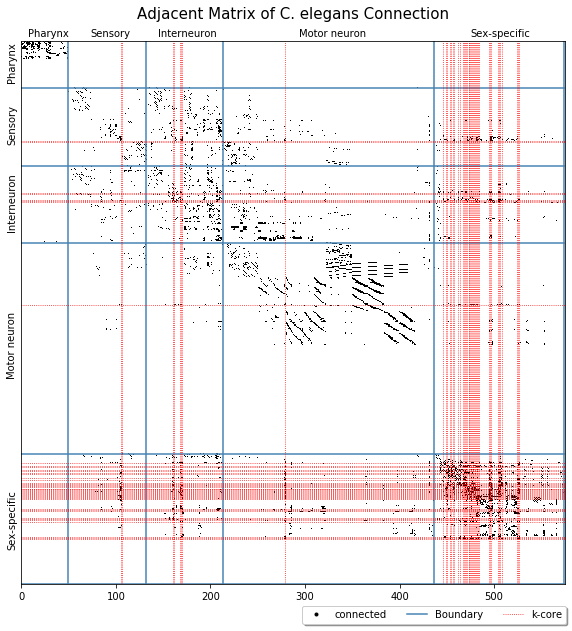

In [240]:
figsize=10
plt.figure("Adjacent Matrix",figsize=figsize*np.array([1,1]))
plt.imshow(df2,cmap='Greys')
plt.title("Adjacent Matrix of C. elegans Connection",loc='center',y=1.03,fontsize=15)

portion=0
for pos in img_dic:
    cen_pos = int((img_dic[pos]+portion)/2)
    plt.text(cen_pos-int(figsize/4*len(pos)),-5,pos)
    plt.text(-15,int((cen_pos+figsize/4*len(pos))),pos,rotation='vertical')
    plt.axhline(y=img_dic[pos],color='steelblue')
    plt.axvline(x=img_dic[pos],color='steelblue')
    ax=plt.gca()
    ax.get_yaxis().set_visible(False)
    portion=img_dic[pos]

for pos in k_net_pos:
    plt.axhline(y=pos,linestyle=':',linewidth=0.8,color='red',alpha=3)
    plt.axvline(x=pos,linestyle=':',linewidth=0.8,color='red',alpha=3)

plt.plot([None],[None],'.',color='black',label='connected')
plt.plot([None],[None],'-',color='steelblue',label='Boundary')
plt.plot([None],[None],linestyle=':',linewidth=0.8,color='red',alpha=3,label='k-core')
plt.legend(loc='upper center', bbox_to_anchor=(0.76,-0.03), shadow=True, ncol=3)

# Directional Abjacent matrix to Undirectional one

In [111]:
def di2undi(A):
    N=max(np.shape(A))
    A_un=np.array(A).copy()
    for idx in range(N):
        for jdx in range(idx+1,N):
            connect=(A_un[idx, jdx] or A_un[jdx,idx])
            A_un[idx,jdx]=1*connect
            A_un[jdx,idx]=1*connect
    return A_un

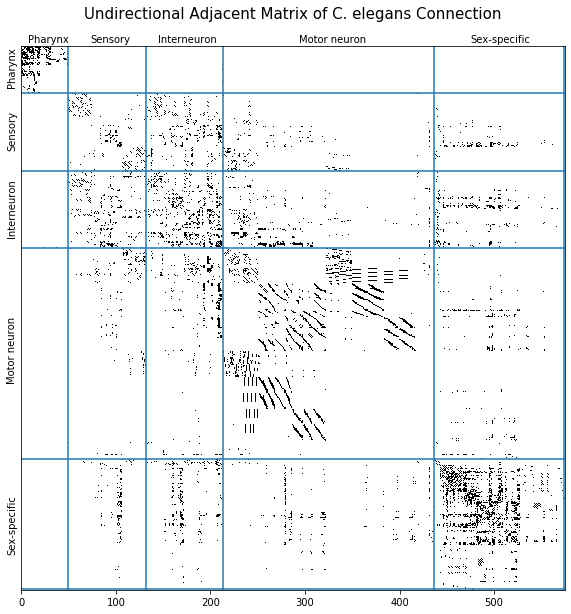

In [112]:
A_un=di2undi(np.array(df2))

figsize=10
plt.figure("Adjacent Matrix",figsize=figsize*np.array([1,1]))
plt.imshow(A_un,cmap='Greys')
plt.title("Undirectional Adjacent Matrix of C. elegans Connection",loc='center',y=1.04,fontsize=15)

portion=0
for pos in img_dic:
    cen_pos = int((img_dic[pos]+portion)/2)
    plt.text(cen_pos-int(figsize/4*len(pos)),-5,pos)
    plt.text(-15,int((cen_pos+figsize/4*len(pos))),pos,rotation='vertical')
    plt.axhline(y=img_dic[pos])
    plt.axvline(x=img_dic[pos])
    ax=plt.gca()
    ax.get_yaxis().set_visible(False)
    portion=img_dic[pos]

In [120]:
dq=0.01
T=10
un_kcore_=np.arange(1,30,1)

un_net=A_un
N=max(np.shape(df2))

un_Mc=[]
q_=np.arange(0,1,dq)

for k in un_kcore_:
    print('-',k,'- core')
    for q in q_:
        node_count=0
        for idx in range(T):
            percol=node_percolation(un_net,q)
            k_net=kcore_net(percol,k)
            node_count += ((k_net.sum(axis=0) >0).sum())*1
        un_Mc.append(node_count/(N*T))

un_Mc=np.array(un_Mc).reshape(len(un_kcore_),int(1/dq))

- 1 - core
- 2 - core
- 3 - core
- 4 - core
- 5 - core
- 6 - core
- 7 - core
- 8 - core
- 9 - core
- 10 - core
- 11 - core
- 12 - core
- 13 - core
- 14 - core
- 15 - core
- 16 - core
- 17 - core
- 18 - core
- 19 - core
- 20 - core
- 21 - core
- 22 - core
- 23 - core
- 24 - core
- 25 - core
- 26 - core
- 27 - core
- 28 - core
- 29 - core


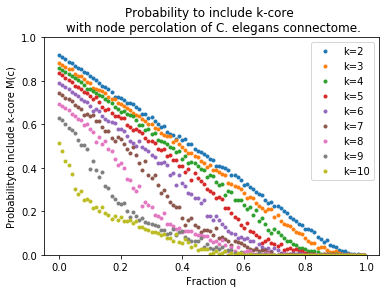

In [121]:
for idx,k in enumerate(kcore_[1:10]):
    plt.plot(q_,un_Mc[int(k-1)],'.',label='k='+str(k))
plt.ylim(0,1)
plt.title("Probability to include k-core \n with node percolation of C. elegans connectome.")
plt.xlabel("Fraction q")
plt.ylabel("Probabilityto include k-core M(c)")
plt.legend()
plt.show()

### $q_{c}$ vs $k-core$ Graph

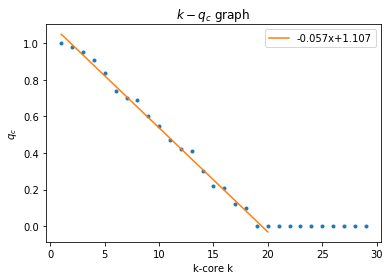

In [280]:
import scipy.optimize as opt

def lin(x,a,b):
    return a*x+b


qc=[]
for Mk in un_Mc:
    idx=np.where(Mk==0)[0]
    if len(idx)==0:
        qc.append(1)
    else:
        qc.append(q_[idx[0]])

x=np.linspace(1,20,100)  
        
plt.figure(r"$k-q_{c}$ graph")
plt.title(r"$k-q_{c}$ graph")
plt.ylabel(r"$q_{c}$")
plt.xlabel(r"k-core k")
plt.plot(kcore_,qc,'.')


popt,pcov = opt.curve_fit(lin,kcore_[:19],qc[:19])
plt.plot(x,lin(x,*popt),label=str(round(popt[0],3))+'x+'+str(round(popt[1],3)))
plt.legend()

# k-core position

In [245]:
k_net=kcore_net(un_net,18)
#connectivity(k_net).render('18-core.png')
k_net_degree=k_net.sum(axis=0)
k_net_pos=np.where(k_net_degree)[0]
un_k_net_nam=df2.columns[k_net_pos]
for idx in k_net_pos:
    print('name:',df2.columns[idx])
    print('positon:',idx2pos(img_dic,idx))

name: PHAR
positon: Sensory
name: PHCL
positon: Sensory
name: PHCR
positon: Sensory
name: AVFL
positon: Interneuron
name: PVNL
positon: Interneuron
name: PVNR
positon: Interneuron
name: AVG
positon: Interneuron
name: PDB
positon: Motor neuron
name: R1BR
positon: Sex-specific
name: R2BL
positon: Sex-specific
name: R2BR
positon: Sex-specific
name: R3BL
positon: Sex-specific
name: R3BR
positon: Sex-specific
name: R4BL
positon: Sex-specific
name: R4BR
positon: Sex-specific
name: R5BR
positon: Sex-specific
name: R6AR
positon: Sex-specific
name: R7AL
positon: Sex-specific
name: R7AR
positon: Sex-specific
name: R7BL
positon: Sex-specific
name: R7BR
positon: Sex-specific
name: R8AL
positon: Sex-specific
name: R8AR
positon: Sex-specific
name: R8BL
positon: Sex-specific
name: R8BR
positon: Sex-specific
name: R9AL
positon: Sex-specific
name: R9AR
positon: Sex-specific
name: R9BL
positon: Sex-specific
name: R9BR
positon: Sex-specific
name: PHDL
positon: Sex-specific
name: PHDR
positon: Sex-specifi

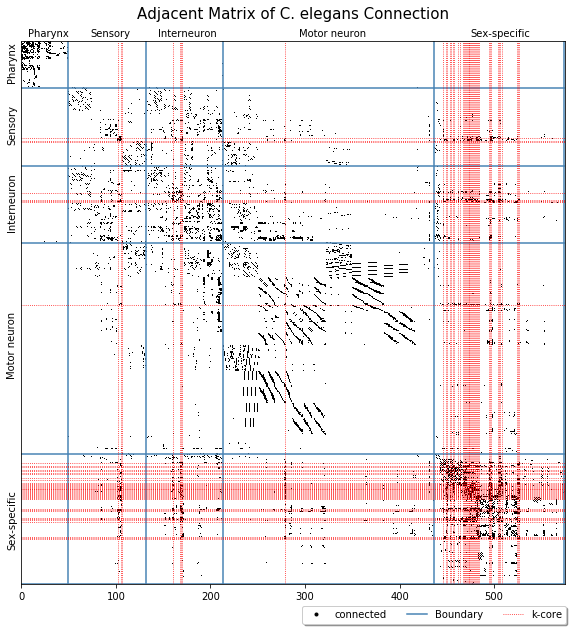

In [243]:
figsize=10
plt.figure("Adjacent Matrix",figsize=figsize*np.array([1,1]))
plt.imshow(A_un,cmap='Greys')
plt.title("Adjacent Matrix of C. elegans Connection",loc='center',y=1.03,fontsize=15)

portion=0
for pos in img_dic:
    cen_pos = int((img_dic[pos]+portion)/2)
    plt.text(cen_pos-int(figsize/4*len(pos)),-5,pos)
    plt.text(-15,int((cen_pos+figsize/4*len(pos))),pos,rotation='vertical')
    plt.axhline(y=img_dic[pos],color='steelblue')
    plt.axvline(x=img_dic[pos],color='steelblue')
    ax=plt.gca()
    ax.get_yaxis().set_visible(False)
    portion=img_dic[pos]

for pos in k_net_pos:
    plt.axhline(y=pos,linestyle=':',linewidth=0.8,color='red',alpha=3)
    plt.axvline(x=pos,linestyle=':',linewidth=0.8,color='red',alpha=3)

plt.plot([None],[None],'.',color='black',label='connected')
plt.plot([None],[None],'-',color='steelblue',label='Boundary')
plt.plot([None],[None],linestyle=':',linewidth=0.8,color='red',alpha=3,label='k-core')
plt.legend(loc='upper center', bbox_to_anchor=(0.76,-0.03), shadow=True, ncol=3)

In [265]:
pd.DataFrame({"Direction":np.append(None,k_net_nam),"undirection":un_k_net_nam})

,Direction,undirection
0,None,PHAR
1,PHCL,PHCL
2,PHCR,PHCR
3,AVFL,AVFL
4,AVFR,PVNL
5,PVNL,PVNR
6,PVNR,AVG
7,AVG,PDB
8,PDB,R1BR
9,R1BR,R2BL
